In [8]:
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
import re
from random import randint
import datetime
import time
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

maxSeqLength = 20 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
    
wordsList = np.load('wordsList.npy')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')

# generate log files here
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print("finished")

finished


Positive files finished
Negative files finished


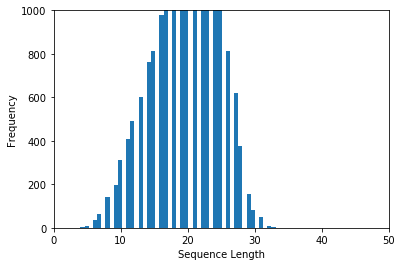

In [9]:
positiveFiles = ['positive/' + f for f in listdir('positive/') if isfile(join('positive/', f))]
negativeFiles = ['negative/' + f for f in listdir('negative/') if isfile(join('negative/', f))]
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

minLength = len(positiveFiles)

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

if (minLength > len(negativeFiles)):
    minLength = len(negativeFiles)

numFiles = len(numWords)

ids = np.zeros((minLength*2, maxSeqLength), dtype='int32')
labels = []
fileCounter = 0
counter = 0
for pf in positiveFiles:
    if (counter >= minLength):
        break
    with open(pf, "r") as f:
        indexCounter = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        labels.append([1,0])
        fileCounter = fileCounter + 1
        counter = counter + 1

counter = 0
for nf in negativeFiles:
    if (counter > minLength):
        break
    with open(nf, "r") as f:
        indexCounter = 0
        line=f.readline()
        cleanedLine = cleanSentences(line)
        split = cleanedLine.split()
        for word in split:
            try:
                ids[fileCounter][indexCounter] = wordsList.index(word)
            except ValueError:
                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
            indexCounter = indexCounter + 1
            if indexCounter >= maxSeqLength:
                break
        labels.append([0,1])
        fileCounter = fileCounter + 1 
        counter = counter + 1
#Pass into embedding function and see if it evaluates. 

labels = np.asarray(labels)
np.save('idsMatrix', ids)
np.save('labels', labels)

plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 50, 0, 1000])
plt.show()
plt.savefig("figures/{}-histogram.png".format(st), format='png')
# generate log files here

In [10]:
ids = np.load('idsMatrix.npy')
labels = np.load('labels.npy')

ids, labels = shuffle(ids, labels, random_state = 0)
lastTrainingIndex = int(round(len(ids) * .90))
ids = np.split(ids, [lastTrainingIndex, len(ids)])
labels = np.split(labels, [lastTrainingIndex, len(labels)])
trainingLabels = labels[0]
testingLabels = labels[1]
trainingIds = ids[0]
testingIds = ids[1]

def getTrainBatch(counter):
    label = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        arr[i] = trainingIds[counter-1:counter]
        label.append(trainingLabels[counter-1])
        if (counter >= len(trainingIds) - 1):
            counter = 1
        else:
            counter = counter + 1
    return arr, label, counter

def getTestBatch(counter):
    label = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        arr[i] = testingIds[counter-1:counter]
        label.append(testingLabels[counter-1])
        if (counter >= len(testingIds) - 1):
            counter = 1
        else:
            counter = counter + 1
    return arr, label, counter

batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 1000

tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

In [11]:
counter = 1
for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels, counter = getTrainBatch(counter)
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
   
   #Write summary to Tensorboard
   if (i % 50 == 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
       writer.add_summary(summary, i)

   #Save the network every 10,000 training iterations
   if (i % 10000 == 0 and i != 0):
       save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
writer.close()

print("finished")

finished


In [12]:
saver.restore(sess, tf.train.latest_checkpoint('models'))

counter = 1

iterations = 10000
# for i in range(iterations):
#     nextBatch, nextBatchLabels, counter = getTestBatch(counter)
#     print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
#     runlog.write("Accuracy for this batch: {}\n".format((sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100))

pp = 0
nn = 0
npp = 0
pn = 0

for i in range(iterations):
    nextBatch, nextBatchLabels, counter = getTestBatch(counter)
    predictions = sess.run(prediction, {input_data: nextBatch, labels: nextBatchLabels})
    for index in range(len(predictions)):
        positive_sentiment, negative_sentiment = predictions[index][0], predictions[index][1]
        if (positive_sentiment > negative_sentiment):
            if ([1,0] == nextBatchLabels[index].tolist()):
                pp = pp + 1
            else:
                npp = npp + 1
        else:
            if ([0,1] == nextBatchLabels[index].tolist()):
                nn = nn + 1
            else:
                pn = pn + 1

INFO:tensorflow:Restoring parameters from models/pretrained_lstm.ckpt-100000


In [14]:
runlog = open("logs/{}.txt".format(st),"w+")
runlog.write("Sequence Length: {}\n".format(maxSeqLength))
runlog.write("# of Dimensions: {}\n".format(numDimensions))
runlog.write('# of files: {}\n'.format(numFiles))
runlog.write('Total # of words: {}\n'.format(sum(numWords)))
runlog.write('Average # of words: {}\n'.format(sum(numWords)/len(numWords)))
runlog.write('# of files per class: {}\n'.format(minLength))
runlog.write("Batch Size: {}\n".format(batchSize))
runlog.write("Number of Classes: {}\n".format(numClasses))
runlog.write("Training Iterations: {}\n".format(iterations))
runlog.write("Testing Accuracy: {}\n".format((pp + nn) /(pp + nn + npp + pn)))
runlog.close()

print("done")

done
